[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset shape: (2782, 5)
rating
5    1444
1     546
4     464
3     198
2     130
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78       169
           1       0.87      0.99      0.92       388

    accuracy                           0.89       557
   macro avg       0.91      0.82      0.85       557
weighted avg       0.90      0.89      0.88       557



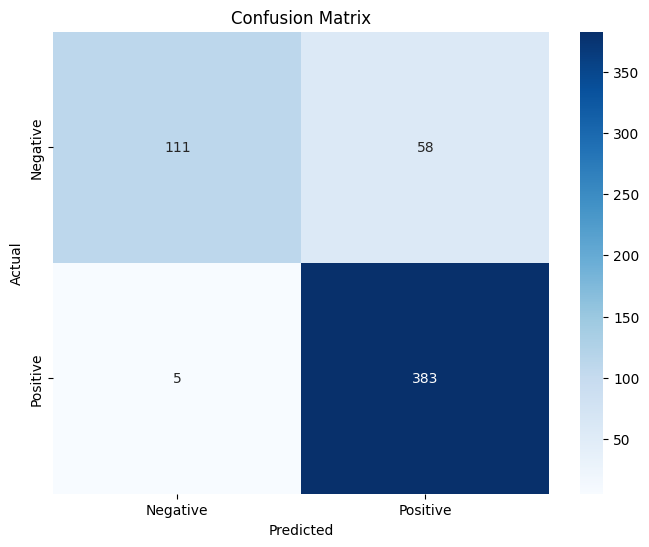


Top Positive Words:
super: 1.3109
chocolate: 1.3317
excellent: 1.4422
well: 1.4756
little: 1.4761
long: 1.5252
tasty: 1.6207
perfect: 1.7611
amazing: 1.8510
happy: 2.0027
awesome: 2.0371
love: 2.3552
good: 2.5131
best: 2.9113
nice: 3.2428

Top Negative Words:
bad: -1.5028
seal: -1.5329
damaged: -1.5988
opened: -1.7119
received: -1.7759
didnt: -1.7835
dust: -1.7937
fake: -1.8518
packet: -1.8689
duplicate: -1.9511
waste: -2.0519
buy: -2.0765
return: -2.1243
disappointed: -2.4146
dont: -2.4727

New Review Sentiment Analysis:
Review: This product is amazing! Best purchase ever.
Sentiment: Positive (Confidence: 0.91)

Review: Terrible quality, broke after one week.
Sentiment: Positive (Confidence: 0.58)

Review: It's okay, nothing special but does the job.
Sentiment: Positive (Confidence: 0.79)



In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load data
df = pd.read_csv("/content/amazon_vfl_reviews.csv")
print(f"Dataset shape: {df.shape}")
print(df['rating'].value_counts())

# Create binary sentiment labels (positive/negative)
df['sentiment'] = df['rating'].apply(lambda x: 1 if x > 3 else 0)

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['review'].astype(str).apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['sentiment'], test_size=0.2, random_state=42
)

# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vect, y_train)

# Evaluate
y_pred = model.predict(X_test_vect)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance (top positive and negative words)
feature_names = vectorizer.get_feature_names_out()
coef = model.coef_[0]

# Top positive words
top_positive_idx = coef.argsort()[-15:]
top_positive = [(feature_names[i], coef[i]) for i in top_positive_idx]
print("\nTop Positive Words:")
for word, score in top_positive:
    print(f"{word}: {score:.4f}")

# Top negative words
top_negative_idx = coef.argsort()[:15]
top_negative = [(feature_names[i], coef[i]) for i in top_negative_idx]
print("\nTop Negative Words:")
for word, score in reversed(top_negative):
    print(f"{word}: {score:.4f}")

# Predict sentiment for new reviews
new_reviews = [
    "This product is amazing! Best purchase ever.",
    "Terrible quality, broke after one week.",
    "It's okay, nothing special but does the job."
]

# Preprocess and predict
new_processed = [preprocess_text(review) for review in new_reviews]
new_vectors = vectorizer.transform(new_processed)
new_predictions = model.predict(new_vectors)
new_proba = model.predict_proba(new_vectors)

# Display results
print("\nNew Review Sentiment Analysis:")
for i, review in enumerate(new_reviews):
    sentiment = "Positive" if new_predictions[i] == 1 else "Negative"
    confidence = new_proba[i][new_predictions[i]]  # Probability of the predicted class
    print(f"Review: {review}")
    print(f"Sentiment: {sentiment} (Confidence: {confidence:.2f})\n")